##**Datasets & Libaries**

In [1]:
# --- STEP 1: Update Pustaka untuk mengatasi ModuleNotFoundError ---
print("⏳ Memperbarui pustaka scikit-learn dan imbalanced-learn...")

# Perbarui scikit-learn (Wajib: minimal v1.2)
!pip install --upgrade scikit-learn

# Perbarui imbalanced-learn (Disarankan: untuk memastikan kompatibilitas)
!pip install --upgrade imbalanced-learn

# Pastikan Sastrawi juga ada
!pip install Sastrawi

print("\n✅ Instalasi selesai. Anda mungkin perlu menjalankan kembali KESELURUHAN Notebook.")

⏳ Memperbarui pustaka scikit-learn dan imbalanced-learn...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 11.6 MB/s eta 0:00:00

✅ Instalasi selesai. Anda mungkin perlu menjalankan kembali KESELURUHAN Notebook.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Library NLP
import nltk

# Menghapus 'punkt_tab' karena tidak standar, NLTK akan menggunakan 'punkt' di bawah.
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from imblearn.over_sampling import SMOTE # Ini sekarang akan bekerja

# Library Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- PENTING: Perbaiki NLTK LookupError ---
print("⏳ Memastikan NLTK Resources tersedia...")
try:
    # Mengunduh resource yang diperlukan untuk tokenisasi dan stopwords
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)

    # Import fungsi setelah download
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize

    print("✅ NLTK Resources berhasil diunduh.")
except Exception as e:
    print(f"⚠️ Gagal mengunduh NLTK resources: {e}")

# --- Inisialisasi Sumber Daya NLP Lanjutan ---
try:
    LIST_STOPWORDS = set(stopwords.words('indonesian'))
    STEMMER_FACTORY = StemmerFactory()
    STEMMER = STEMMER_FACTORY.create_stemmer()
    print("✅ Stopwords dan Stemmer Sastrawi siap.")
except Exception as e:
    print(f"❌ Error inisialisasi Sastrawi: {e}")
    LIST_STOPWORDS = set()
    STEMMER = None

⏳ Memastikan NLTK Resources tersedia...
✅ NLTK Resources berhasil diunduh.
✅ Stopwords dan Stemmer Sastrawi siap.


In [3]:
df = pd.read_csv('/content/dataset_sms_spam_v1.csv', on_bad_lines='skip')
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [5]:
# Atau cara alternatif yang lebih sederhana menggunakan .replace dan .loc:
df['Label_Baru'] = df['label'].replace({0: 'ham', 1: 'spam', 2: 'spam'})
# Jika hanya ingin mengganti semua selain 0 menjadi 'spam':
df['Label_Baru'] = df['label'].apply(lambda x: 'spam' if x in [1, 2] else 'ham')

In [6]:
df.head()

,Teks,label,Label_Baru
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,spam
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,spam
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,spam
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,spam
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,spam


In [7]:
df.rename(columns={
    'Label_Baru': 'Kategori',
    'Teks': 'Pesan'
}, inplace=True)

df.head()

,Pesan,label,Kategori
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,spam
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,spam
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,spam
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,spam
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,spam


In [8]:
df['Kategori'].value_counts()

,count
Kategori,
spam,574
ham,569


Text(0.5, 1.0, 'Distribusi Jumlah Perbandingan Kategori Label')

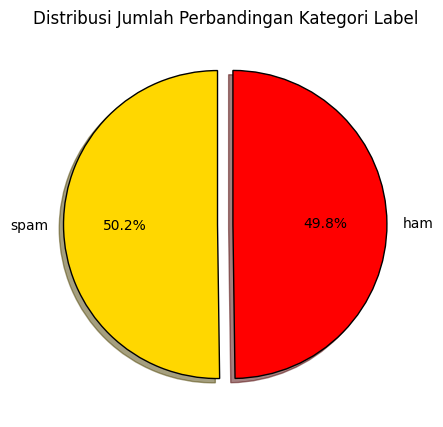

In [9]:
fig = plt.figure(figsize=(5,5))
colors = ("gold", "red")
wp = {'linewidth':1, 'edgecolor':"black"}
tags = df['Kategori'].value_counts()
explode = (0.05, 0.05)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribusi Jumlah Perbandingan Kategori Label')

##**Fungsi Preprocessing**

In [10]:
def caseFolding_and_cleaning(text):
    """Mengubah ke lowercase, menghapus pola URL/HTML/path noise, alamat email, dan tanda baca."""
    text = str(text).lower()
    text = re.sub(r"https?:\/\/\S+|www\.\S+|(\/.*?\?)|(<.*?>)", " ", text)
    text = re.sub(r'\S+@\S+', 'EMAIL_ADDRESS', text)
    translator = str.maketrans('', '', string.punctuation.replace('@', '').replace('.', ''))
    text = text.translate(translator)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def advanced_normalization(text):
    """Melakukan decoding, menangani karakter berulang, mengganti angka, tokenisasi, stopword removal, dan stemming."""
    text = text.replace('%20', ' ').replace('%3c', '<').replace('%3e', '>').replace('%2f', '/')
    text = text.replace('&#x2f;', '/').replace('&#x2e;', '.')
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\d+', 'NUM', text)

    tokens = word_tokenize(text)

    tokens = [word for word in tokens if word not in LIST_STOPWORDS]

    if STEMMER:
        tokens = [STEMMER.stem(word) for word in tokens]

    return ' '.join(tokens)

def full_preprocessing(text):
    """Menjalankan keseluruhan alur preprocessing."""
    text = caseFolding_and_cleaning(text)
    text = advanced_normalization(text)
    return text

In [11]:
from tqdm import tqdm

In [12]:
tqdm.pandas()

In [14]:
import nltk

# Asumsi df sudah di-load dan fungsi full_preprocessing sudah didefinisikan

# --- PENTING: Perbaiki NLTK LookupError ---
print("⏳ Memastikan NLTK 'punkt_tab' Resources tersedia...")
try:
    nltk.download('punkt_tab', quiet=True)
    print("✅ NLTK 'punkt_tab' Resources berhasil diunduh.")
except Exception as e:
    print(f"⚠️ Gagal mengunduh NLTK 'punkt_tab' resources: {e}")


print("Memulai proses pembersihan teks (Cleaning and Preprocessing)...")

df['Pesan_Bersih'] = df['Pesan'].progress_apply(full_preprocessing)

print("Proses pembersihan teks selesai!")

⏳ Memastikan NLTK 'punkt_tab' Resources tersedia...
✅ NLTK 'punkt_tab' Resources berhasil diunduh.
Memulai proses pembersihan teks (Cleaning and Preprocessing)...


100%|██████████| 1143/1143 [05:50<00:00,  3.26it/s]

Proses pembersihan teks selesai!


In [15]:
df['Pesan_Bersih'].head()

,Pesan_Bersih
0,promo beli paket flash numgb my telkomsel app ...
1,num num gbnum rp num ribu spesial pilih aktif...
2,num num plg yth sisa kuota flash numkb downlo...
3,num num plg yth sisa kuota flash numkb downlo...
4,num numgbnum rp num ribu spesial pilih aktif ...


In [16]:
unique_labels = df['Kategori'].unique()
print(f"Label yang ditemukan: {unique_labels}")

Label yang ditemukan: ['spam' 'ham']


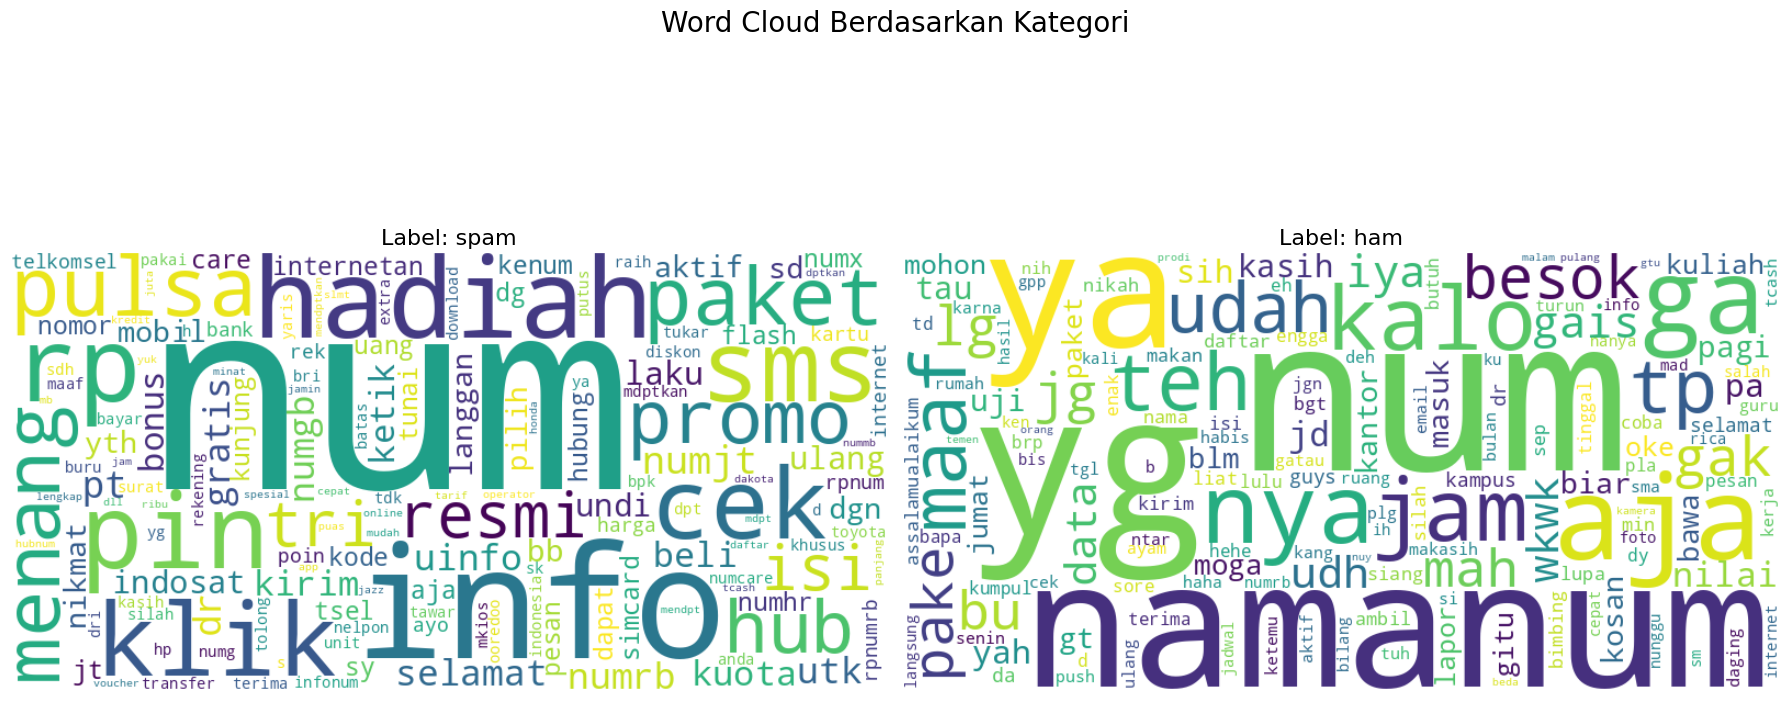

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Konfigurasi visualisasi
fig, axes = plt.subplots(1, len(unique_labels), figsize=(18, 9)) # Membuat subplot sebanyak jumlah label

for i, label in enumerate(unique_labels):

    # --- Langkah 1: Filter Data ---
    # Memfilter dataframe hanya untuk baris dengan label tertentu
    df_filtered = df[df['Kategori'] == label]

    # --- Langkah 2: Gabungkan Teks Bersih ---
    # Gabungkan semua teks bersih dari kelompok ini menjadi satu string besar
    all_cleaned_words = ' '.join(df_filtered['Pesan_Bersih'])

    if not all_cleaned_words:
        print(f"Tidak ada data teks yang diproses untuk label: {label}")
        continue

    # --- Langkah 3: Generate Word Cloud ---
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=150, # Batasi kata per kelompok
        colormap='viridis', # Gunakan colormap berbeda jika perlu
        collocations=False
    ).generate(all_cleaned_words)

    # --- Langkah 4: Visualisasi ---
    # Menampilkan word cloud di subplot yang sesuai
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off") # Sembunyikan sumbu
    axes[i].set_title(f'Label: {label}', fontsize=16)

plt.suptitle('Word Cloud Berdasarkan Kategori', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Sesuaikan layout agar judul tidak bertabrakan
plt.show()

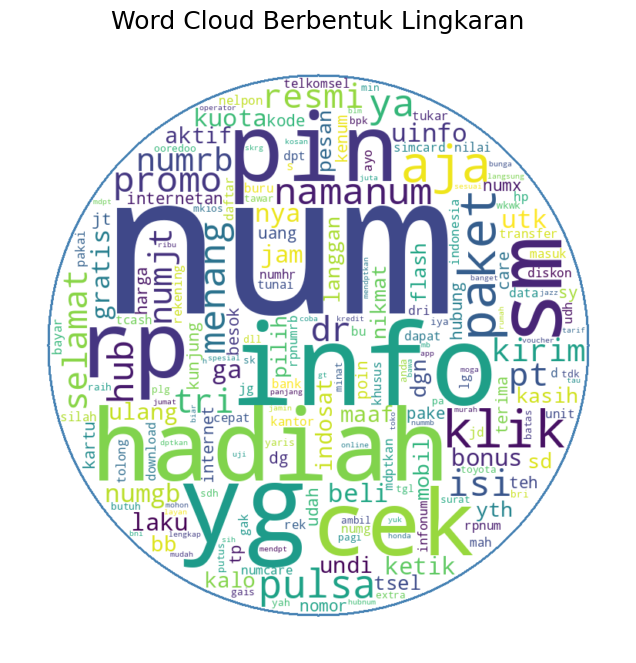

In [18]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# --- 1. MEMBUAT MASKER LINGKARAN (Menggantikan Pemuatan File) ---
# Tentukan ukuran masker (resolusi)
x, y = np.ogrid[:800, :800] # Membuat grid 800x800

# Buat masker lingkaran: True (putih) di dalam radius 350, False (hitam) di luar
# Koordinat pusat lingkaran: 400, 400
# Radius lingkaran: 350
mask = (x - 400)**2 + (y - 400)**2 > 350**2

# Ubah nilai Boolean menjadi 255 (putih) dan 0 (hitam) untuk WordCloud
# WordCloud akan mengisi area yang bernilai 255
mask_lingkaran = 255 * mask.astype(int)


# --- 2. Siapkan Data (Asumsi df dan 'Pesan_Bersih' sudah ada) ---
# Misalnya, gabungkan semua pesan bersih
all_cleaned_words = ' '.join(df['Pesan_Bersih'])


# --- 3. Konfigurasi WordCloud dengan Masker Lingkaran ---
wordcloud = WordCloud(
    width=800,
    height=800, # Sesuaikan tinggi dan lebar agar sesuai dengan masker
    background_color='white',
    max_words=200,
    mask=mask_lingkaran, # <--- GUNAKAN MASKER LINGKARAN
    colormap='viridis', # Sesuaikan warna sesuai selera Anda
    contour_width=3,
    contour_color='steelblue',
    collocations=False,
    random_state=42
).generate(all_cleaned_words)


# --- 4. Visualisasi ---
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud Berbentuk Lingkaran', fontsize=18)
plt.show()

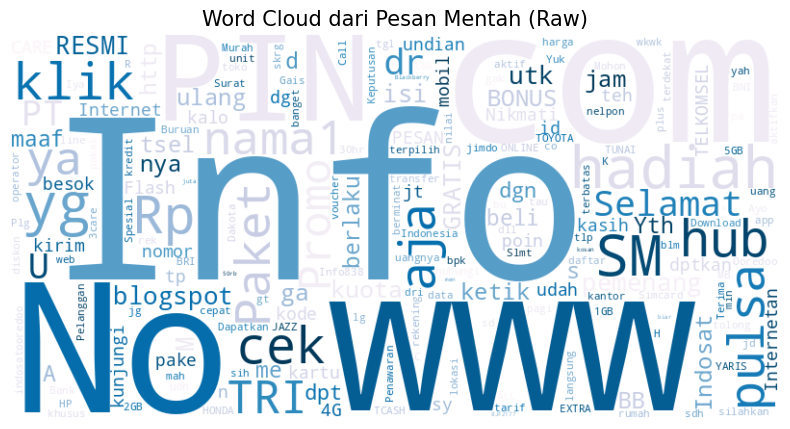

In [19]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Asumsi df sudah di-load dengan kolom 'Pesan'

# --- 1. Gabungkan Teks Mentah ---
# Kita tetap perlu mengubahnya menjadi string tunggal
all_raw_words = ' '.join(df['Pesan'].astype(str)) # Pastikan semua baris berupa string


# --- 2. Konfigurasi WordCloud ---
# Kita bisa manfaatkan fitur 'stopwords' bawaan WordCloud untuk menghapus kata umum
from nltk.corpus import stopwords
list_stopwords = stopwords.words('indonesian')

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    # Tambahkan stop words BHS INDONESIA standar untuk mengurangi noise dasar
    stopwords=set(list_stopwords),
    colormap='PuBu',
    collocations=False
).generate(all_raw_words) # Input adalah teks mentah

# --- 3. Visualisasi ---
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud dari Pesan Mentah (Raw)', fontsize=15)
plt.show()

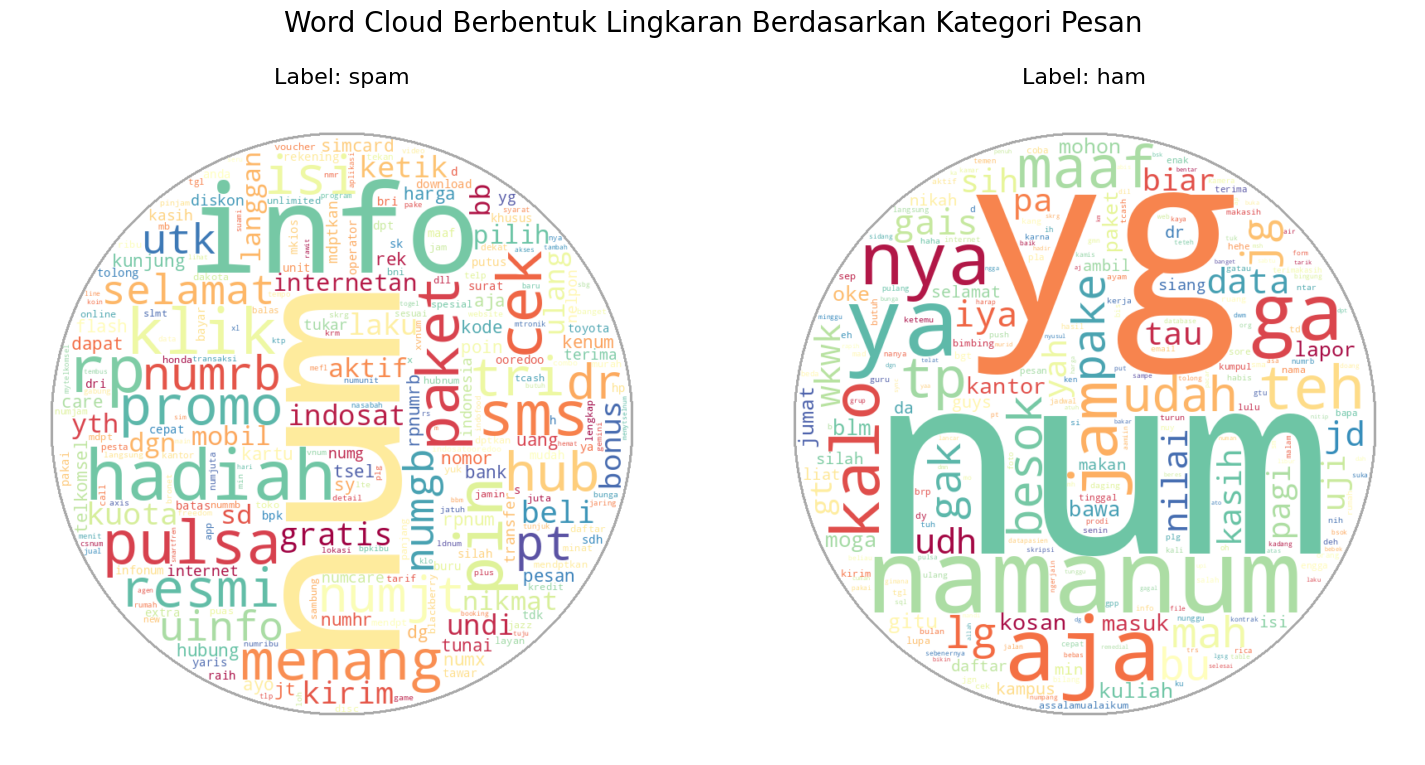

In [20]:
# --- 3. PENGATURAN VISUALISASI DAN MASKER ---

# Membuat Masker Lingkaran (800x800)
# --- Kode Masker yang Diperbaiki ---

def create_circle_mask_fixed(size=800, radius=350):
    x, y = np.ogrid[:size, :size]

    # Kriteria untuk area DI LUAR lingkaran (background)
    # Area DI DALAM lingkaran akan False/0 (Hitam) -> area yang akan diisi teks
    mask_logic = (x - size/2)**2 + (y - size/2)**2 > radius**2

    # Ubah menjadi 255 di luar lingkaran (background), 0 di dalam lingkaran (bentuk)
    mask_array = 255 * mask_logic.astype(np.uint8)

    # Opsional: Jika Anda ingin latar belakang di luar lingkaran berwarna hitam (0)
    # dan lingkaran yang diisi teks berwarna putih (255) di array:
    # return 255 - mask_array

    # Namun, cara paling andal adalah memuat gambar dengan background hitam.
    # Mari kita gunakan cara paling andal: membuat lingkaran hitam di latar putih

    # --- Cara Paling Benar dan Sederhana ---
    # Buat array penuh putih (255)
    mask_array = 255 * np.ones((size, size), dtype=np.uint8)

    # Tentukan pusat dan radius
    center_x, center_y = size // 2, size // 2

    # Atur area di dalam lingkaran menjadi 0 (Hitam) -> area yang akan diisi teks
    for i in range(size):
        for j in range(size):
            if (i - center_x)**2 + (j - center_y)**2 < radius**2:
                mask_array[i, j] = 0 # 0 (Hitam) adalah area yang diisi

    return mask_array


# Ganti pemanggilan maskernya di kode eksekusi Anda:
mask_lingkaran = create_circle_mask_fixed(size=800, radius=350)

# mask_lingkaran = create_circle_mask(size=800, radius=350)

# --- 4. GENERATE DAN TAMPILKAN WORD CLOUD PER LABEL ---

unique_labels = df['Kategori'].unique()
fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 8))

# Jika hanya ada satu label, axes[i] tidak bisa di-indexing, jadi kita buat list
if len(unique_labels) == 1:
    axes = [axes]

for i, label in enumerate(unique_labels):

    # Filter Data
    df_filtered = df[df['Kategori'] == label]
    all_cleaned_words = ' '.join(df_filtered['Pesan_Bersih'])

    if not all_cleaned_words:
        print(f"Skipping: Tidak ada data teks untuk label: {label}")
        continue

    # Generate Word Cloud
    wordcloud = WordCloud(
        width=800,
        height=800, # Harus sama dengan ukuran masker
        background_color='white',
        max_words=250,
        mask=mask_lingkaran, # MASKER LINGKARAN
        colormap='Spectral', # Skema warna, coba 'BrBG', 'GnBu', atau 'Spectral'
        contour_width=3,
        contour_color='darkgray',
        collocations=False
    ).generate(all_cleaned_words)

    # Visualisasi di Subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f'Label: {label}', fontsize=16)

plt.suptitle('Word Cloud Berbentuk Lingkaran Berdasarkan Kategori Pesan', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

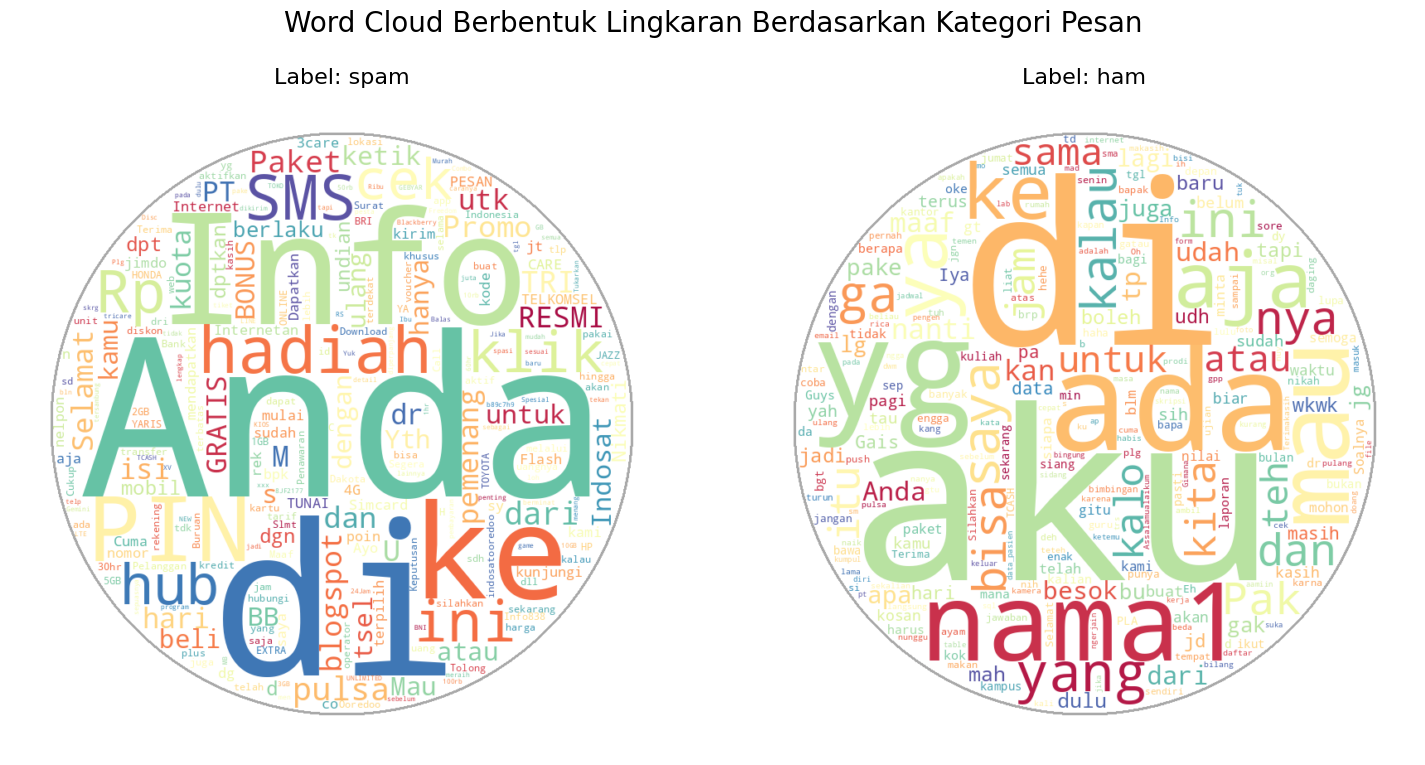

In [21]:
# --- 3. PENGATURAN VISUALISASI DAN MASKER ---

# Membuat Masker Lingkaran (800x800)
# --- Kode Masker yang Diperbaiki ---

def create_circle_mask_fixed(size=800, radius=350):
    x, y = np.ogrid[:size, :size]

    # Kriteria untuk area DI LUAR lingkaran (background)
    # Area DI DALAM lingkaran akan False/0 (Hitam) -> area yang akan diisi teks
    mask_logic = (x - size/2)**2 + (y - size/2)**2 > radius**2

    # Ubah menjadi 255 di luar lingkaran (background), 0 di dalam lingkaran (bentuk)
    mask_array = 255 * mask_logic.astype(np.uint8)

    # Opsional: Jika Anda ingin latar belakang di luar lingkaran berwarna hitam (0)
    # dan lingkaran yang diisi teks berwarna putih (255) di array:
    # return 255 - mask_array

    # Namun, cara paling andal adalah memuat gambar dengan background hitam.
    # Mari kita gunakan cara paling andal: membuat lingkaran hitam di latar putih

    # --- Cara Paling Benar dan Sederhana ---
    # Buat array penuh putih (255)
    mask_array = 255 * np.ones((size, size), dtype=np.uint8)

    # Tentukan pusat dan radius
    center_x, center_y = size // 2, size // 2

    # Atur area di dalam lingkaran menjadi 0 (Hitam) -> area yang akan diisi teks
    for i in range(size):
        for j in range(size):
            if (i - center_x)**2 + (j - center_y)**2 < radius**2:
                mask_array[i, j] = 0 # 0 (Hitam) adalah area yang diisi

    return mask_array


# Ganti pemanggilan maskernya di kode eksekusi Anda:
mask_lingkaran = create_circle_mask_fixed(size=800, radius=350)

# mask_lingkaran = create_circle_mask(size=800, radius=350)

# --- 4. GENERATE DAN TAMPILKAN WORD CLOUD PER LABEL ---

unique_labels = df['Kategori'].unique()
fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 8))

# Jika hanya ada satu label, axes[i] tidak bisa di-indexing, jadi kita buat list
if len(unique_labels) == 1:
    axes = [axes]

for i, label in enumerate(unique_labels):

    # Filter Data
    df_filtered = df[df['Kategori'] == label]
    all_cleaned_words = ' '.join(df_filtered['Pesan'])

    if not all_cleaned_words:
        print(f"Skipping: Tidak ada data teks untuk label: {label}")
        continue

    # Generate Word Cloud
    wordcloud = WordCloud(
        width=800,
        height=800, # Harus sama dengan ukuran masker
        background_color='white',
        max_words=250,
        mask=mask_lingkaran, # MASKER LINGKARAN
        colormap='Spectral', # Skema warna, coba 'BrBG', 'GnBu', atau 'Spectral'
        contour_width=3,
        contour_color='darkgray',
        collocations=False
    ).generate(all_cleaned_words)

    # Visualisasi di Subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f'Label: {label}', fontsize=16)

plt.suptitle('Word Cloud Berbentuk Lingkaran Berdasarkan Kategori Pesan', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Pipeline Utama: Pemrosesan Data, Pelatihan, dan Evaluasi**


A. MEMUAT DATASET
✅ Data berhasil dimuat. Total baris: 1143

B. PROSES PREPROCESSING DAN NORMALISASI
Processing Index 0...
Processing Index 500...
Processing Index 1000...
--- Contoh Data yang Sudah Dinormalisasi ---
                                        Pesan_mentah  \
0  [PROMO] Beli paket Flash mulai 1GB di MY TELKO...   
1  2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...   
2  2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...   
3  2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...   
4  4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...   

                                    pesan_normalized kategori  
0  promo beli paket flash numgb my telkomsel app ...     spam  
1  num num gbnum rp num ribu spesial pilih  aktif...     spam  
2  num num plg yth sisa kuota flash numkb  downlo...     spam  
3  num num plg yth sisa kuota flash numkb  downlo...     spam  
4  num numgbnum rp num ribu spesial pilih  aktif ...     spam  

Ukuran Data Latih: 914 | Ukuran Data Uji: 229

D. EKSTRAKSI 

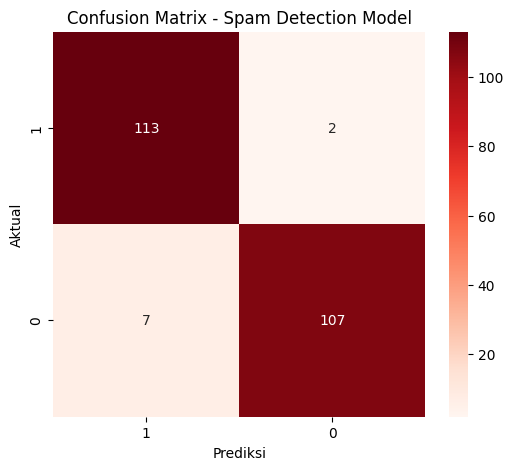

In [24]:
def run_spam_detection_pipeline(file_path):
    """Menjalankan seluruh pipeline dari data hingga evaluasi."""

    # --- A. MEMUAT DATASET ---
    print("\n" + "="*50)
    print("A. MEMUAT DATASET")
    print("="*50)

    try:
        # PENTING: Sesuaikan fungsi pembacaan data jika file Anda bukan CSV (misal: read_excel)
        df = pd.read_csv(file_path)

        # --- START FIX: Apply the same column transformations as done globally ---
        # Create 'Label_Baru' from 'label' (from cell nlZHZ6Jz5BFP)
        df['Label_Baru'] = df['label'].apply(lambda x: 'spam' if x in [1, 2] else 'ham')

        # Rename columns (from cell aNovH-Ub5LLI)
        df.rename(columns={
            'Label_Baru': 'Kategori',
            'Teks': 'Pesan'
        }, inplace=True)
        # --- END FIX ---

        # Membersihkan baris dengan nilai yang hilang (NaN) jika ada
        # This line can now execute successfully as 'Kategori' and 'Pesan' exist.
        df.dropna(subset=['Kategori', 'Pesan'], inplace=True)

        # Memastikan hanya kolom yang diperlukan yang digunakan
        df = df[['Kategori', 'Pesan']].copy()

        print(f"✅ Data berhasil dimuat. Total baris: {len(df)}")

    except FileNotFoundError:
        print(f"❌ ERROR: File dataset '{file_path}' tidak ditemukan.")
        return None, None # Return None for both vectorizer and model in case of error

    # --- B. PREPROCESSING & NORMALISASI ---
    print("\n" + "="*50)
    print("B. PROSES PREPROCESSING DAN NORMALISASI")
    print("="*50)

    Dataset_Normalized = list()

    for index, row in df.iterrows():
        if index % 500 == 0:
            print(f'Processing Index {index}...')

        text_mentah = row['Pesan']

        # Panggil fungsi full_preprocessing yang sudah disempurnakan
        pesan_normalized = full_preprocessing(text_mentah)

        Dataset_Normalized.append({
            "Pesan_mentah" : text_mentah,
            "pesan_normalized" : pesan_normalized,
            "kategori" : row['Kategori']
        })

    df_normalized = pd.DataFrame(Dataset_Normalized)

    print("--- Contoh Data yang Sudah Dinormalisasi ---")
    print(df_normalized[['Pesan_mentah', 'pesan_normalized', 'kategori']].head())

    # --- C. PEMBAGIAN DATA ---

    X = df_normalized['pesan_normalized'] # Feature: teks bersih
    y = df_normalized['kategori'].map({'ham': 0, 'spam': 1}) # Target: label numerik (0=ham, 1=spam)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\nUkuran Data Latih: {len(X_train)} | Ukuran Data Uji: {len(X_test)}")

    # --- D. EKSTRAKSI FITUR (TF-IDF) ---
    print("\n" + "="*50)
    print("D. EKSTRAKSI FITUR (TF-IDF)")
    print("="*50)

    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2), # Menggunakan unigram dan bigram
        min_df=5           # Kata harus muncul di minimal 5 dokumen
    )
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    print(f"Jumlah Fitur (Kata Unik) yang diekstrak: {len(vectorizer.get_feature_names_out())}")

    # --- E. PELATIHAN MODEL ---
    print("\n" + "="*50)
    print("E. PELATIHAN MODEL (Multinomial Naive Bayes)")
    print("="*50)

    model = LinearSVC(random_state=42, dual=False)
    model.fit(X_train_vec, y_train)
    print("✅ Pelatihan Model Selesai.")

    # --- F. EVALUASI MODEL ---
    print("\n" + "="*50)
    print("F. EVALUASI MODEL")
    print("="*50)

    y_pred = model.predict(X_test_vec)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"⭐ Akurasi Model: {accuracy*100:.2f}%")

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(pd.DataFrame(cm, index=['Aktual Ham (0)', 'Aktual Spam (1)'], columns=['Prediksi Ham (0)', 'Prediksi Spam (1)']))

    print("\nClassification Report (Precision, Recall, F1-Score):")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    cm = confusion_matrix(y_test, y_pred, labels=y.unique())
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=y.unique(), yticklabels=y.unique())
    plt.title('Confusion Matrix - Spam Detection Model') # Corrected line
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()

    return vectorizer, model

# --- Jalankan Pipeline dengan Nama File Dataset Anda ---

if __name__ == "__main__":
    # GANTI 'nama_file_dataset_anda.csv' dengan path/nama file Anda yang sebenarnya
    FILE_DATASET = '/content/dataset_sms_spam_v1.csv'
    # Capture the returned vectorizer and model
    global vectorizer, model
    vectorizer, model = run_spam_detection_pipeline(FILE_DATASET)

**Uji Coba Data Baru**

In [25]:
# --- H. UJI COBA PADA DATA BARU (INFERENSI) ---
print("\n" + "="*50)
print("G. UJI COBA PADA DATA BARU")
print("="*50)

# 1. Definisikan teks email baru yang ingin Anda uji
# Anda bisa mengganti teks ini dengan input dari user atau file
new_email_list = [
    "Selamat! Anda terpilih untuk hadiah mobil mewah. Klik link ini untuk klaim sekarang juga.",
    "Konfirmasi pemesanan tiket pesawat Anda. Mohon siapkan kode booking saat check-in. Terima kasih.",
    "Mohon cek laporan bulanan yang baru saja saya kirimkan via email. Terima kasih."
]

print(f"📧 Teks 1: '{new_email_list[0]}'")
print(f"📧 Teks 2: '{new_email_list[1]}'")
print(f"📧 Teks 3: '{new_email_list[2]}'")

# 2. Preprocess Teks Baru
# Terapkan fungsi preprocessing yang sama persis seperti saat training!
processed_new_emails = [full_preprocessing(e) for e in new_email_list]

print("\n⚙️ Teks Setelah Preprocessing:")
print(processed_new_emails)

# 3. Vectorization (Transformasi Fitur)
# PENTING: Gunakan objek 'vectorizer' yang sudah di-fit pada data training.
# JANGAN gunakan .fit_transform(), hanya .transform()!
# Ensure vectorizer is available globally
if 'vectorizer' not in globals():
    raise NameError("Vectorizer object not found. Please run the training pipeline first.")
new_email_vec = vectorizer.transform(processed_new_emails)

# 4. Prediksi
# Ensure model is available globally
if 'model' not in globals():
    raise NameError("Model object not found. Please run the training pipeline first.")
predictions = model.predict(new_email_vec)

# 5. Output Hasil
label_map = {0: "NON-SPAM (HAM) ✅", 1: "SPAM ❌"}
print("\n--- Hasil Deteksi ---")

for i, pred in enumerate(predictions):
    result = label_map[pred]
    print(f"Email {i+1} ({predictions[i]}): **{result}**")


G. UJI COBA PADA DATA BARU
📧 Teks 1: 'Selamat! Anda terpilih untuk hadiah mobil mewah. Klik link ini untuk klaim sekarang juga.'
📧 Teks 2: 'Konfirmasi pemesanan tiket pesawat Anda. Mohon siapkan kode booking saat check-in. Terima kasih.'
📧 Teks 3: 'Mohon cek laporan bulanan yang baru saja saya kirimkan via email. Terima kasih.'

⚙️ Teks Setelah Preprocessing:
['selamat pilih hadiah mobil mewah  klik link klaim ', 'konfirmasi mesan tiket pesawat  mohon siap kode booking checkin  terima kasih ', 'mohon cek lapor bulan kirim via email  terima kasih ']

--- Hasil Deteksi ---
Email 1 (1): **SPAM ❌**
Email 2 (0): **NON-SPAM (HAM) ✅**
Email 3 (0): **NON-SPAM (HAM) ✅**


**SAVE MODEL**

In [26]:
import joblib
import os

# --- Model dan Vectorizer sudah dilatih ---

# Definisikan nama file yang akan disimpan
MODEL_FILENAME = "spam_pesan_model_svm.joblib"
VECTORIZER_FILENAME = "tfidf_vectorizer_spam_svm.joblib"

# 1. Simpan Model Klasifikasi
joblib.dump(model, MODEL_FILENAME)
print(f"✅ Model berhasil disimpan sebagai: {MODEL_FILENAME}")

# 2. Simpan Vectorizer (TF-IDF)
joblib.dump(vectorizer, VECTORIZER_FILENAME)
print(f"✅ Vectorizer berhasil disimpan sebagai: {VECTORIZER_FILENAME}")

✅ Model berhasil disimpan sebagai: spam_pesan_model_svm.joblib
✅ Vectorizer berhasil disimpan sebagai: tfidf_vectorizer_spam_svm.joblib


In [27]:
import pickle
import os

# --- Model dan Vectorizer sudah dilatih ---

# Anggap Anda sudah memiliki objek ini dari pelatihan
# model = MultinomialNB() # Contoh model
# vectorizer = TfidfVectorizer() # Contoh vectorizer

# Definisikan nama file yang akan disimpan
MODEL_FILENAME_PKL = "spam_pesan_model_svm.pkl" # Ubah ekstensi menjadi .pkl (pickle)
VECTORIZER_FILENAME_PKL = "tfidf_vectorizer_spam_svm.pkl" # Ubah ekstensi menjadi .pkl (pickle)

# 1. Simpan Model Klasifikasi menggunakan pickle
try:
    with open(MODEL_FILENAME_PKL, 'wb') as file:
        pickle.dump(model, file)
    print(f"✅ Model berhasil disimpan sebagai: {MODEL_FILENAME_PKL}")
except NameError:
    print("⚠️ Error: Variabel 'model' belum terdefinisi. Pastikan Anda sudah melatih model Anda.")
except Exception as e:
    print(f"❌ Gagal menyimpan model: {e}")


# 2. Simpan Vectorizer (TF-IDF) menggunakan pickle
try:
    with open(VECTORIZER_FILENAME_PKL, 'wb') as file:
        pickle.dump(vectorizer, file)
    print(f"✅ Vectorizer berhasil disimpan sebagai: {VECTORIZER_FILENAME_PKL}")
except NameError:
    print("⚠️ Error: Variabel 'vectorizer' belum terdefinisi. Pastikan Anda sudah melatih vectorizer Anda.")
except Exception as e:
    print(f"❌ Gagal menyimpan vectorizer: {e}")

✅ Model berhasil disimpan sebagai: spam_pesan_model_svm.pkl
✅ Vectorizer berhasil disimpan sebagai: tfidf_vectorizer_spam_svm.pkl
